# Graduation Rates at PelotonU
This project hypothesizes that the graduation rate for the Hybrid College nonprofit organization, PelotonU, follows a Poisson distribution.

Let's start with the pre-reqs

In [724]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
from scipy.stats import chi2
from IPython.display import display, Math, Latex

Let's define some quick helper functions and variables.

In [725]:
# A global variable to be our main column name
col_name = 'Degree Completion Date'
# Takes a row value and returns the month
def getMonth(row):
    # date = datetime.strptime(row[col_name], '%m/%d/%Y')
    return row[col_name].month

# Takes a row value and returns the year
def getYear(row):
    # date = datetime.strptime(row[col_name], '%m/%d/%Y')
    return row[col_name].year

# Takes a row value and returns the month and year
def getMonthYear(row):
    # date = datetime.strptime(row[col_name], '%m/%d/%Y')
    return str (row[col_name].month)+"-"+str (row[col_name].year)

# Takes a row index and lambda. It returns the poisson probability value 
def getPoissProb(row, l):
    k = row.name
    probability = (pow(l, k)*math.exp(-l))/math.factorial(k)
    return probability

# Takes a row index and total months. It returns expected probability 
def getExpectedProb(row, n):
    return row['Probabilities']*n

# Takes a row index and returns actual frequency minus the expected frquency
def FminNP(row,n):
    return row['Actual Frequencies']-(n*row['Probabilities'])

# Takes a row index and returns actual frequency minus the expected frquency
def FminNPsqrd(row, n):
    return pow(row['Actual Frequencies']-(n*row['Probabilities']), 2)

# Takes a row index and returns actual frequency minus the expected frquency
def x_sqr_approx(row):
    numerator = pow(row['Actual Frequencies']-row['Expected Frequencies'], 2)
    return numerator/row['Expected Frequencies']

Now let's download our spreadsheet data and format it to be helpful.

In [726]:
# Read Excel Sheet
df = pd.read_excel(r'../all_completion_dates.xlsx', sheet_name='Sheet1')
# The length is the total amount of graduations
total_graduations = len(df.index)
# Let's convert all of our dates to datetime objects
df[col_name] = df.apply(lambda row: datetime.strptime(row[col_name], '%m/%d/%Y'), axis=1)

# Filter out our months
df['month'] = df.apply(lambda row: getMonth(row), axis=1)
# Filter out our years
df['year'] = df.apply(lambda row: getYear(row), axis=1)
# Combine our month and year columns to help with frequency distribution
df['month-year']= df.apply(lambda row: getMonthYear(row), axis=1)

# Let's sort our dates in ascending order
df = df.sort_values(by=col_name)
# Let's save our earliest grad
earliestGradDate = df[col_name].iloc[0]
# Let's save our latest grad
latestGradDate = df[col_name].iloc[total_graduations-1]

display(df)


,Degree Completion Date,month,year,month-year
61,2016-06-27,6,2016,6-2016
86,2016-09-10,9,2016,9-2016
23,2016-12-21,12,2016,12-2016
32,2017-02-11,2,2017,2-2017
35,2017-02-18,2,2017,2-2017
...,...,...,...,...
7,2022-10-10,10,2022,10-2022
8,2022-10-19,10,2022,10-2022
10,2022-10-27,10,2022,10-2022
19,2022-11-06,11,2022,11-2022


Let's get the frequency distribution of the data.

In [727]:
# Let's make a copy of our data frame
agg_df = pd.DataFrame()
# Group the new dataframe by our month-year column values
agg_df = df.groupby(['month-year']).count().reset_index()
# Get rid of the original date data. We won't need it anymore.
agg_df.drop(col_name, inplace=True, axis=1)
# Get rid of the month column. We don't need it.
agg_df.drop('month', inplace=True, axis=1)
# Get rid of the year column. We also don't need it.
agg_df.rename(columns={"year":"count"}, inplace=True)
display(agg_df)

# Suppressing some future deprecation warnings.
print(len(agg_df))
warnings.filterwarnings("ignore")

,month-year,count
0,1-2018,1
1,1-2019,1
2,1-2020,3
3,1-2022,1
4,10-2017,2
5,10-2018,1
6,10-2020,2
7,10-2022,4
8,11-2017,1
9,11-2019,1


52


Our data doesn't account for months with no grads. How many months are those?

In [737]:
# Get a general datetime object of elapsed dates from the first to last graduation
elapsedDates = relativedelta(latestGradDate, earliestGradDate)
# Turn this general datetime object to months
elapsedMonths = elapsedDates.months+elapsedDates.years*12
# Use elapsed months to find our lambda for the poisson distribution
poissLambda = total_graduations/elapsedMonths
# Get a discrete number on the number of months that had no grads
count_monthsNoGrads = elapsedMonths-len(agg_df)

print("We have",count_monthsNoGrads, "months total with no grads.")
print(poissLambda, "students graduate per month")

We have 24 months total with no grads.
1.236842105263158 students graduate per month


Great! Now let's append these months to our frequency distribution dataframe.

In [729]:
# Let's create a new dataframe
df_agg = pd.DataFrame()
# Copy over our previous dataframe
df_agg = agg_df

# Into our new dataframe let's add our months with no grads
counter = 0
while(counter < count_monthsNoGrads):
    df_agg = df_agg.append({'month-year': '0-0', 'count':0}, ignore_index=True)
    counter = counter+1

display(df_agg)

,month-year,count
0,1-2018,1
1,1-2019,1
2,1-2020,3
3,1-2022,1
4,10-2017,2
...,...,...
71,0-0,0
72,0-0,0
73,0-0,0
74,0-0,0


From here, we can display the frequency distribution in a table.

In [730]:
# Create a new dataframe and insert our df_agg dataframe grouped by our count column values
frequencies = pd.DataFrame({'Actual Frequencies' : df_agg.groupby(["count"]).size()})
# Let's sort our frequencies dataframe
frequencies = frequencies.sort_values(by=["count", "Actual Frequencies"], ignore_index=True)
display(frequencies)


,Actual Frequencies
0,24
1,26
2,17
3,4
4,4
5,1


We can also display this frequency distribution on a histogram.

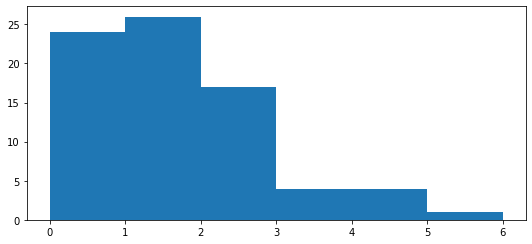

In [731]:
# Show our frequncy in a histogram
plt.hist(df_agg['count'], bins=[0, 1, 2, 3, 4, 5, 6])
plt.show()

We can create a poisson pdf diagram with our λ, poissLambda variable, and overlay it above our histogram to see the similarities.

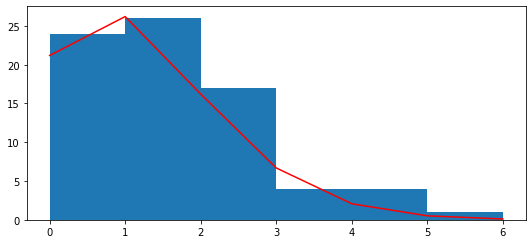

In [738]:
# Make x values for our Poisson PDF
x = np.arange(0, 7, 1)
# Make y values for our Poisson PDF with our custom λ value based on our data.
y = poisson.pmf(x, mu=poissLambda, loc=0)*73
# Recreate our histogram from actual values
plt.hist(df_agg['count'], bins=[0, 1, 2, 3, 4, 5, 6])
# Plot our Poisson PDF above our histogram
plt.plot( x, y, 'r-' )

plt.show()


Let's fill out our frequency dataframe with the following columns:
* poisson probabilities
    - $\lambda$ = the variable poissLambda
* expected frequencies
    - $np_i$
* $\left(f_i-np_i\right)$
* $\left(f_i-np_i\right)^2$
* $\sum_{i=1}^{k}{\frac{\left(f_i-np_i\right)^2}{np_i}}$ ~ $\mathcal{X}_{k-1}^2$

In [739]:
frequencies['Probabilities'] = frequencies.apply(lambda row: getPoissProb(row, poissLambda), axis=1)
frequencies['Expected Frequencies'] = frequencies.apply(lambda row: getExpectedProb(row, elapsedMonths), axis=1)
frequencies['(f-np)'] = frequencies.apply(lambda row: FminNP(row, elapsedMonths), axis=1)
frequencies['(f-np)^2'] = frequencies.apply(lambda row: FminNPsqrd(row, elapsedMonths), axis=1)
frequencies['χ^2_k-1 Approximation'] = frequencies.apply(lambda row: x_sqr_approx(row), axis=1)
actual_frequencies_sum = frequencies['Actual Frequencies'].sum()
X_sqrd = frequencies['χ^2_k-1 Approximation'].sum()

display(frequencies)
print('Σ Actual Frequency values:', actual_frequencies_sum)
display(Math(r'\mathcal{X}^2=\sum_{i=1}^{k}{\frac{{(f_i-np_i)}^2}{np_i}=}'), X_sqrd)

,Actual Frequencies,Probabilities,Expected Frequencies,(f-np),(f-np)^2,χ^2_k-1 Approximation
0,24,0.290300,22.062763,1.937237,3.752889,0.170101
1,26,0.359055,27.288154,-1.288154,1.659340,0.060808
2,17,0.222047,16.875569,0.124431,0.015483,0.000917
3,4,0.091546,6.957471,-2.957471,8.746637,1.257157
4,4,0.028307,2.151323,1.848677,3.417605,1.588606
5,1,0.007002,0.532169,0.467831,0.218865,0.411270


Σ Actual Frequency values: 76


<IPython.core.display.Math object>

3.488859729366961

Now we plot this $\mathcal{X}^2=\sum_{i=1}^{k}{\frac{{(f_i-np_i)}^2}{np_i}}$ value against a Chi-Squared distribution with an $\alpha=0.05$

$H_0:f\left(x\right)=Poisson\left(\lambda=poissLambda\right)$

$H_A:f\left(x\right)\neq\ Poisson\left(\lambda=poissLambda\right)$

$\alpha=0.05$

In [744]:
alpha = 0.05
k=frequencies['Actual Frequencies'].count()
df = k-1-1

print("k =",k)
print("df =",df)

k = 6
df = 4


We reject $H_0$ if 
$\mathcal{X}^2>\mathcal{X}^2_{\alpha}=$ 